<a href="https://colab.research.google.com/github/books-by-chansung/low-code-ai/blob/main/chapter7/Customer_Churn_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 비즈니스 사용 사례: 고객 이탈 예측

이 프로젝트에서 목표는 통신 회사의 고객 이탈을 예측하는 것입니다.
고객 이탈은 고객 이탈률을 의미하며, 즉 고객이 서비스를 중단하기로 선택하는 비율입니다.
통신 회사는 종종 제품을 월별 요금이나 연간 계약으로 판매하므로, 여기서 이탈은 고객이 다음 달에 구독이나 계약을 취소하는 경우를 의미합니다.

이 노트북에서 다루는 작업에 대한 전체 설명과 해설은 책의 7장을 참조하세요.


## 판다스, 맷플롯립, Seaborn으로 데이터셋 탐색하기


먼저 이 노트북에 필요한 패키지들을 불러옵니다. 여기에는 나중에 다룰 사이킷런 및 텐서플로가 포함됩니다.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import tensorflow as tf


2023-09-20 20:31:40.009177: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-20 20:31:40.039670: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-20 20:31:40.248156: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-20 20:31:40.249254: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-20 20:31:41.133552: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

진행하기에 앞서 사이킷런 및 텐서플로의 버전을 확인합니다

In [ ]:
print("scikit-learn version:", sklearn.__version__)
print("TensorFlow version:", tf.__version__)


scikit-learn version: 1.3.0
TensorFlow version: 2.13.0


고객 이탈 데이터셋을 포함하는 CSV 파일을 가져와 판다스의 데이터프레임으로 만듭니다

In [ ]:
file_loc = 'https://storage.googleapis.com/low-code-ai-book/churn_dataset.csv'
df_raw = pd.read_csv(file_loc)

`df_raw` 데이터프레임의 `head()` 메서드를 통해 처음 다섯 개의 데이터를 확인합니다.

In [ ]:
df_raw.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

`df_raw` 데이터프레임의 각 열에 대한 데이터 유형을 탐색합니다. 참고로 `TotalCharges` 열은 예상과는 다른 데이터 유형입니다.

In [ ]:
df_raw.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

describe() 메서드를 통해 TotalCharges 열에 대해 몇 가지 고수준의 통계 정보를 확인합니다.


In [ ]:
df_raw['TotalCharges'].describe()

count     7043
unique    6531
top           
freq        11
Name: TotalCharges, dtype: object

`True` 또는 `False`를 반환하는 간단한 마스크를 생성하여, `df_raw`를 필터링하고 `TotalCharges` 열의 값이 비어있는 행만 반환합니다

In [ ]:
mask = (df_raw['TotalCharges']==' ')
df_raw[mask].head()


customerID  gender  SeniorCitizen Partner Dependents  tenure  \
488   4472-LVYGI  Female              0     Yes        Yes       0   
753   3115-CZMZD    Male              0      No        Yes       0   
936   5709-LVOEQ  Female              0     Yes        Yes       0   
1082  4367-NUYAO    Male              0     Yes        Yes       0   
1340  1371-DWPAZ  Female              0     Yes        Yes       0   

     PhoneService     MultipleLines InternetService       OnlineSecurity  ...  \
488            No  No phone service             DSL                  Yes  ...   
753           Yes                No              No  No internet service  ...   
936           Yes                No             DSL                  Yes  ...   
1082          Yes               Yes              No  No internet service  ...   
1340           No  No phone service             DSL                  Yes  ...   

         DeviceProtection          TechSupport          StreamingTV  \
488                   Yes                  Yes                  Yes   
753   No internet service  No internet service  No internet service   
936                   Yes                   No                  Yes   
1082  No internet service  No internet service  No internet service   
1340                  Yes                  Yes                  Yes   

          StreamingMovies  Contract PaperlessBilling  \
488                    No  Two year              Yes   
753   No internet service  Two year               No   
936                   Yes  Two year               No   
1082  No internet service  Two year               No   
1340                   No  Two year               No   

                  PaymentMethod MonthlyCharges  TotalCharges Churn  
488   Bank transfer (automatic)          52.55                  No  
753                Mailed check          20.25                  No  
936                Mailed check          80.85                  No  
1082               Mailed check          25.75                  No  
1340    Credit card (automatic)          56.05                  No  

[5 rows x 21 columns]

tenure 값이 0이라면, 이 고객들은 통신사에서 첫 달을 보내고 있으며, 아직 요금이 청구되지 않은 것입니다.

이 가설을 검증하기 위해 다른 마스크를 사용하여 tenure가 0인 행을 확인하세요.


In [ ]:
mask = (df_raw['tenure']==0)
df_raw[mask][['tenure','TotalCharges']]


tenure TotalCharges
488        0             
753        0             
936        0             
1082       0             
1340       0             
3331       0             
3826       0             
4380       0             
5218       0             
6670       0             
6754       0

`TotalCharges` 열의 빈 값을 `0.0`으로 대체하고, 모든 행이 처리되었는지 확인합니다.


In [ ]:
df_1 = df_raw.replace({'TotalCharges': {' ': 0.0}})
mask = (df_raw['tenure']==0)
df_1[mask][['tenure','TotalCharges']]

tenure TotalCharges
488        0          0.0
753        0          0.0
936        0          0.0
1082       0          0.0
1340       0          0.0
3331       0          0.0
3826       0          0.0
4380       0          0.0
5218       0          0.0
6670       0          0.0
6754       0          0.0

`TotalCharges` 열을 올바르게 `float64` 유형으로 변환합니다.


In [ ]:
df_2 = df_1.astype({'TotalCharges':'float64'})
df_2.dtypes


customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

`TotalCharges` 열과 다른 수치형 열에 대한 요약 통계를 탐색합니다.


In [ ]:
df_2.describe()

SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7043.000000  7043.000000     7043.000000   7043.000000
mean        0.162147    32.371149       64.761692   2279.734304
std         0.368612    24.559481       30.090047   2266.794470
min         0.000000     0.000000       18.250000      0.000000
25%         0.000000     9.000000       35.500000    398.550000
50%         0.000000    29.000000       70.350000   1394.550000
75%         0.000000    55.000000       89.850000   3786.600000
max         1.000000    72.000000      118.750000   8684.800000

선택적 키워드 파라미터인 `include`를 `include='all'`로 설정하여 `object` 유형의 열에 대한 통계도 포함시킵니다.


In [ ]:
df_2.describe(include='all')

customerID gender  SeniorCitizen Partner Dependents       tenure  \
count         7043   7043    7043.000000    7043       7043  7043.000000   
unique        7043      2            NaN       2          2          NaN   
top     7590-VHVEG   Male            NaN      No         No          NaN   
freq             1   3555            NaN    3641       4933          NaN   
mean           NaN    NaN       0.162147     NaN        NaN    32.371149   
std            NaN    NaN       0.368612     NaN        NaN    24.559481   
min            NaN    NaN       0.000000     NaN        NaN     0.000000   
25%            NaN    NaN       0.000000     NaN        NaN     9.000000   
50%            NaN    NaN       0.000000     NaN        NaN    29.000000   
75%            NaN    NaN       0.000000     NaN        NaN    55.000000   
max            NaN    NaN       1.000000     NaN        NaN    72.000000   

       PhoneService MultipleLines InternetService OnlineSecurity  ...  \
count          7043          7043            7043           7043  ...   
unique            2             3               3              3  ...   
top             Yes            No     Fiber optic             No  ...   
freq           6361          3390            3096           3498  ...   
mean            NaN           NaN             NaN            NaN  ...   
std             NaN           NaN             NaN            NaN  ...   
min             NaN           NaN             NaN            NaN  ...   
25%             NaN           NaN             NaN            NaN  ...   
50%             NaN           NaN             NaN            NaN  ...   
75%             NaN           NaN             NaN            NaN  ...   
max             NaN           NaN             NaN            NaN  ...   

       DeviceProtection TechSupport StreamingTV StreamingMovies  \
count              7043        7043        7043            7043   
unique                3           3           3               3   
top                  No          No          No              No   
freq               3095        3473        2810            2785   
mean                NaN         NaN         NaN             NaN   
std                 NaN         NaN         NaN             NaN   
min                 NaN         NaN         NaN             NaN   
25%                 NaN         NaN         NaN             NaN   
50%                 NaN         NaN         NaN             NaN   
75%                 NaN         NaN         NaN             NaN   
max                 NaN         NaN         NaN             NaN   

              Contract PaperlessBilling     PaymentMethod MonthlyCharges  \
count             7043             7043              7043    7043.000000   
unique               3                2                 4            NaN   
top     Month-to-month              Yes  Electronic check            NaN   
freq              3875             4171              2365            NaN   
mean               NaN              NaN               NaN      64.761692   
std                NaN              NaN               NaN      30.090047   
min                NaN              NaN               NaN      18.250000   
25%                NaN              NaN               NaN      35.500000   
50%                NaN              NaN               NaN      70.350000   
75%                NaN              NaN               NaN      89.850000   
max                NaN              NaN               NaN     118.750000   

        TotalCharges  Churn  
count    7043.000000   7043  
unique           NaN      2  
top              NaN     No  
freq             NaN   5174  
mean     2279.734304    NaN  
std      2266.794470    NaN  
min         0.000000    NaN  
25%       398.550000    NaN  
50%      1394.550000    NaN  
75%      3786.600000    NaN  
max      8684.800000    NaN  

[11 rows x 21 columns]

`PhoneService`와 `MultipleLines` 열에서 고유한 값 조합을 계산합니다.


In [ ]:
df_2.value_counts(['PhoneService','MultipleLines'])

PhoneService  MultipleLines   
Yes           No                  3390
              Yes                 2971
No            No phone service     682
Name: count, dtype: int64

더 많은 열에 대한 값 개수를 계산합니다. 해석을 쉽게 하기 위해 이 작업을 쌍으로 또는 세 개씩 묶어 탐색하는 것이 좋습니다.


In [ ]:
df_2.value_counts(['InternetService', 'OnlineSecurity', 'OnlineBackup', 'StreamingTV', 'StreamingMovies'])

InternetService  OnlineSecurity       OnlineBackup         StreamingTV          StreamingMovies    
No               No internet service  No internet service  No internet service  No internet service    1526
Fiber optic      No                   No                   No                   No                      521
                                                           Yes                  Yes                     455
DSL              No                   No                   No                   No                      453
Fiber optic      No                   Yes                  Yes                  Yes                     428
                 Yes                  Yes                  Yes                  Yes                     270
DSL              Yes                  No                   No                   No                      246
                                      Yes                  No                   No                      233
Fiber optic      No                 

계약 유형에 따라 통신사를 떠난 고객과 그렇지 않은 고객의 비율을 이해하기 위해 누적 막대 그래프를 생성합니다.


<Axes: xlabel='Contract'>

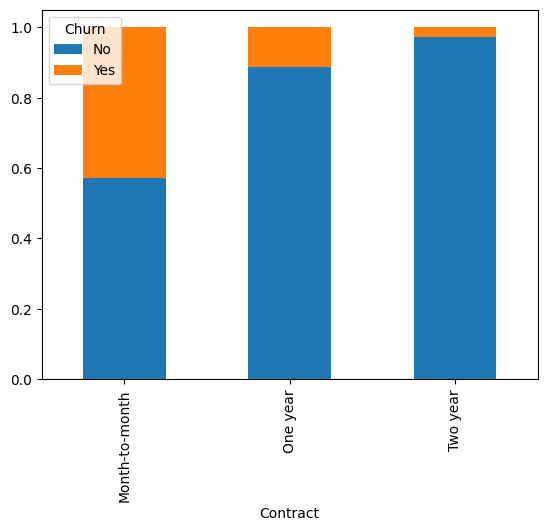

In [ ]:
(df_2.groupby('Contract')['Churn'].value_counts(normalize=True)
  .unstack('Churn')
  .plot.bar(stacked=True))


특성 이름을 입력 매개변수로 사용하여 위의 분포 차트를 생성하는 함수를 만듭니다. 이를 통해 다른 특성에 대한 차트를 반복하지 않고 더 빠르게 생성할 수 있습니다.


In [ ]:
def plot_cat_feature_dist(feature_name):
  (df_2.groupby(feature_name)['Churn'].value_counts(normalize=True)
    .unstack('Churn')
    .plot.bar(stacked=True))


새 함수가 이전과 동일한 차트를 반환하는지 확인합니다.


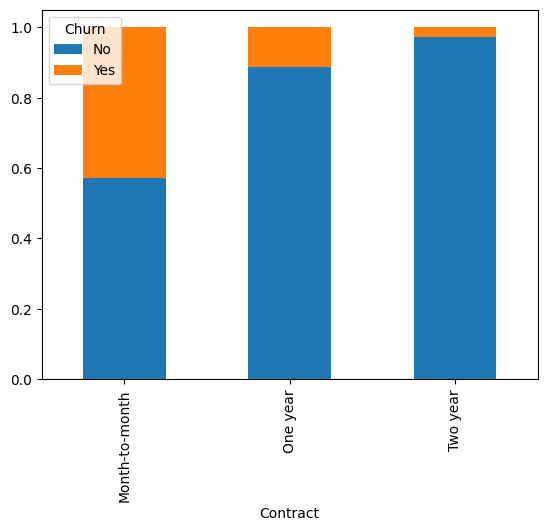

In [ ]:
plot_cat_feature_dist('Contract')

각 고객의 평균 월 청구액을 계산한 후, 현재 청구액과 평균 월 청구액의 차이를 계산하여 시간이 지나면서 청구액이 어떻게 변했는지 파악합니다.


In [ ]:
df_2['AvgMonthlyCharge'] = df_2['TotalCharges']/df_2['tenure']
df_2['DiffCharges'] = df_2['MonthlyCharges']-df_2['AvgMonthlyCharge']
df_2['DiffCharges'].describe()


count    7032.000000
mean       -0.001215
std         2.616165
min       -18.900000
25%        -1.160179
50%         0.000000
75%         1.147775
max        19.125000
Name: DiffCharges, dtype: float64

`tenure` 값이 0.0인 경우 `np.inf` 값을 대체하고 `AvgMonthlyCharge`와 `DiffCharges` 열을 다시 계산합니다.


In [ ]:
df_2['AvgMonthlyCharge'] = df_2['TotalCharges'].div(df_2['tenure']).replace(np.inf,0)
df_2['DiffCharges'] = df_2['MonthlyCharges']-df_2['AvgMonthlyCharge']
df_2['DiffCharges'].describe()


count    7032.000000
mean       -0.001215
std         2.616165
min       -18.900000
25%        -1.160179
50%         0.000000
75%         1.147775
max        19.125000
Name: DiffCharges, dtype: float64

`cut()` 메서드를 사용하여 `DiffCharges` 열을 5개의 버킷으로 나누고, 이전에 정의한 `plot_cat_feature_dist` 함수를 사용하여 각 버킷에서 계정을 취소한 고객 비율을 시각화합니다.

**경고**: Pandas의 향후 버전에서는 `pd.cut`의 첫 번째 입력에 대한 예상 데이터 유형이 변경될 예정입니다. `TypeError`가 발생하면 주석 처리된 코드를 대신 실행하세요.


/tmp/ipykernel_81140/3210634970.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (df_2.groupby(feature_name)['Churn'].value_counts(normalize=True)


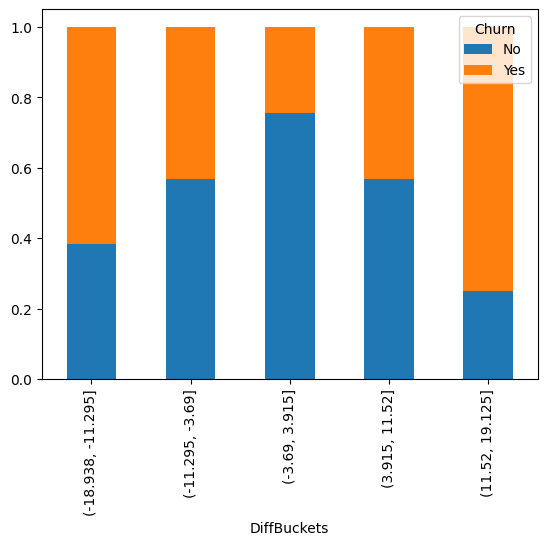

In [ ]:
df_2['DiffBuckets'] = pd.cut(df_2['DiffCharges'], bins=5)
plot_cat_feature_dist('DiffBuckets')

# df_2['DiffBuckets'] = pd.cut(df_2['DiffCharges'].values, bins=5)
# plot_cat_feature_dist('DiffBuckets')

`MonthlyCharges` 열에 대해 동일한 버킷화 및 플로팅 작업을 수행합니다.


/tmp/ipykernel_81140/3210634970.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (df_2.groupby(feature_name)['Churn'].value_counts(normalize=True)


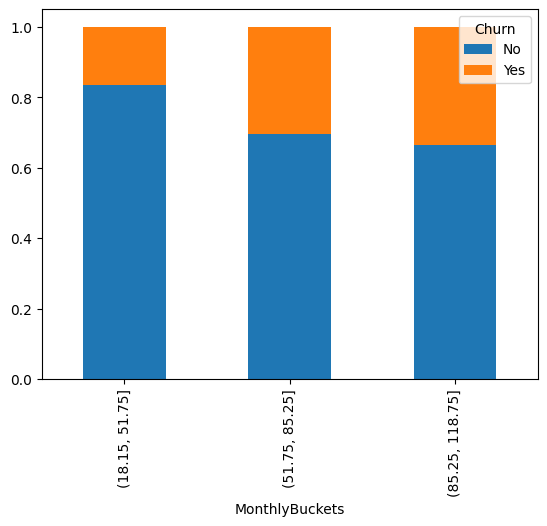

In [ ]:
df_2['MonthlyBuckets'] = pd.cut(df_2['MonthlyCharges'], bins=3)
plot_cat_feature_dist('MonthlyBuckets')


## 판다스와 사이킷런으로 특징 변환하기

이제 데이터셋의 다양한 열을 탐색하고, 이들 간의 상호작용과 레이블과의 관계를 살펴보았습니다. 이제는 데이터를 사용자 정의 모델에 사용할 수 있도록 준비할 것입니다. 먼저, ML 모델 훈련에 사용할 열을 선택하고, 그 다음에 그 특징들을 훈련에 더 적합한 형태로 변환할 것입니다.


목표와 관련이 없거나 중복되는 열을 삭제합니다.

In [ ]:
df_3 = df_2.copy()
df_3 = df_3.drop(columns=['gender','StreamingTV',
                          'StreamingMovies','PhoneService'])
df_3.columns


Index(['customerID', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'AvgMonthlyCharge', 'DiffCharges', 'DiffBuckets', 'MonthlyBuckets'],
      dtype='object')

최종 모델에 유용하지 않은 시각화를 위해 사용된 계산된 열을 삭제합니다.


In [ ]:
df_3 =df_3.drop(columns=['TotalCharges','AvgMonthlyCharge',
                         'DiffCharges','MonthlyBuckets'])


지나치게 구체적인 `customerID` 열은 머신 러닝 모델을 학습시키는 데 유용하지 않으므로 삭제합니다.


In [ ]:
df_3 = df_3.drop(columns=['customerID'])
df_3.dtypes

SeniorCitizen          int64
Partner               object
Dependents            object
tenure                 int64
MultipleLines         object
InternetService       object
OnlineSecurity        object
OnlineBackup          object
DeviceProtection      object
TechSupport           object
Contract              object
PaperlessBilling      object
PaymentMethod         object
MonthlyCharges       float64
Churn                 object
DiffBuckets         category
dtype: object

여러 열에서 `No internet service` 값을 `No`로 대체한 후, 해당 열에 이제 정확히 두 가지 가능한 값이 있는지 확인합니다.


In [ ]:
df_prep = df_3.replace('No internet service', 'No')
df_prep[['OnlineSecurity', 'OnlineBackup',
         'DeviceProtection', 'TechSupport']].nunique()


OnlineSecurity      2
OnlineBackup        2
DeviceProtection    2
TechSupport         2
dtype: int64

수치형 열과 범주형 열을 전처리를 위해 분리합니다. 사이킷런의 `OneHotEncoder` 변환기를 사용하여 범주형 열을 원-핫 인코딩합니다.


In [ ]:
from sklearn.preprocessing import OneHotEncoder

numeric_columns = ['SeniorCitizen', 'tenure', 'MonthlyCharges']
categorical_columns = ['Partner', 'Dependents', 'MultipleLines',
                       'InternetService','OnlineSecurity',
                       'OnlineBackup','DeviceProtection',
                       'TechSupport','Contract','PaperlessBilling',
                       'PaymentMethod','DiffBuckets']

X_num = df_prep[numeric_columns]
X_cat = df_prep[categorical_columns]

ohe = OneHotEncoder(drop='if_binary')
X_cat_trans = ohe.fit_transform(X_cat)


범주형 특징의 첫 번째 행이 올바르게 인코딩되었으며, 디코딩이 가능한지 확인합니다.


In [ ]:
X_cat_trans.toarray()[0]
ohe.inverse_transform(X_cat_trans.toarray())[0]


array(['Yes', 'No', 'No phone service', 'DSL', 'No', 'Yes', 'No', 'No',
       'Month-to-month', 'Yes', 'Electronic check',
       Interval(-3.69, 3.915, closed='right')], dtype=object)

원-핫 인코딩 후 수치형 특징과 범주형 특징을 다시 결합합니다. 모델을 학습시킬 목적으로 레이블 `Churn`을 별도의 배열로 분리합니다.


In [ ]:
X = np.concatenate((X_num.values,X_cat_trans.toarray()), axis=1)
y = df_prep['Churn'].values

`train_test_split` 함수를 사용하여 입력 특징과 레이블을 학습 및 테스트용 데이터셋으로 분리합니다.


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=113)

X_train.shape


(5634, 29)

## 사이킷런으로 로지스틱 회귀 모델 구축

로지스틱 회귀 모델을 생성하고 학습 데이터셋을 사용하여 모델을 학습시킵니다


In [ ]:
from sklearn.linear_model import LogisticRegression

cls = LogisticRegression()

cls.fit(X_train, y_train)


/home/michaelabel/Projects/low-code-ai/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

로지스틱 회귀 모델을 새로 훈련하기 전에 수치형 특징을 0에서 1 사이의 일정한 범위로 다시 조정하기 위해 min-max 스케일링을 수행합니다.


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

cls = LogisticRegression()

cls.fit(X_train_scaled, y_train)


LogisticRegression()

`score()` 메서드로 모델을 평가합니다. 이 모델의 $R^2$ 값이 예상보다 훨씬 낮을 것입니다. 왜 그럴까요?


In [ ]:
cls.score(X_test, y_test)

0.48119233498935415

테스트 데이터셋에 학습 데이터셋에 사용한 것과 동일한 변환을 적용하요 크기를 조정합니다.


In [ ]:
X_test_scaled = scaler.transform(X_test)

cls.score(X_test_scaled, y_test)

0.7991483321504613

당신이 훈련한 모델에 대한 오차 행렬은 사이킷런으로 쉽게 계산할 수 있습니다.
이를 위해서는 sklearn.metrics 라이브러리에서 `confusion_matrix` 함수를 사용할 수 있습니다.


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = cls.predict(X_test_scaled)

confusion_matrix(y_test, y_pred, labels=['Yes','No'])


array([[187, 185],
       [ 98, 939]])

사이킷런의 `precision_score` 및 `recall_score` 함수를 활용하여 모델의 정밀도(precision)와 재현율(recall)을 계산합니다


In [ ]:
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(y_test, y_pred,
                                    labels=['Yes','No'], pos_label='Yes'))

print("Recall:", recall_score(y_test, y_pred,
                              labels=['Yes','No'], pos_label='Yes'))


Precision: 0.656140350877193
Recall: 0.5026881720430108


## 사이킷런으로 학습된 모델로 예측 서비스 제공하기

이 데이터를 파싱하고, 앞서 나열된 변환을 수행한 후, 학습된 모델로 예측을 서비스해야 합니다.
다음 코드는 `example` 변수에 로드된 JSON 예제를 통해 이 단계를 설명합니다.


In [ ]:
import json

# 책에 있는 예제 코드가 공간 제약으로 인해 약간 다를 수 있습니다.
example = json.loads('{"customerID": "7090-HPOJU", "gender": "Female", "SeniorCitizen": 0, "Partner": "Yes", "Dependents": "Yes", "tenure": 66,"PhoneService": "Yes", "MultipleLines": "Yes", "InternetService": "DSL","OnlineSecurity": "Yes", "OnlineBackup": "Yes", "DeviceProtection": "Yes","TechSupport": "No", "StreamingTV": "No", "StreamingMovies": "No","Contract": "Month-to-month", "PaperlessBilling": "Yes", "PaymentMethod": "Bank transfer (automatic)", "MonthlyCharges": 67.45, "TotalCharges": "4508.65"}')

ex_df = pd.DataFrame([example])
ex_df['TotalCharges'] = ex_df['TotalCharges'].astype('float64')
ex_df = ex_df.drop(columns=['customerID','gender',
                            'StreamingTV','StreamingMovies',
                            'PhoneService'])

ex_df['AvgMonthlyCharge'] = ex_df['TotalCharges']/ex_df['tenure']
ex_df['DiffCharges'] = ex_df['MonthlyCharges']-ex_df['AvgMonthlyCharge']
ex_df['DiffBuckets'] = pd.cut(ex_df['DiffCharges'],
                           bins=[-18.938,-11.295,-3.69,3.915,11.52,19.125])
ex_df.pop('DiffCharges')

numeric_columns = ['SeniorCitizen', 'tenure', 'MonthlyCharges']
categorical_columns = ['Partner', 'Dependents', 'MultipleLines',
                       'InternetService','OnlineSecurity','OnlineBackup',
                       'DeviceProtection','TechSupport','Contract',
                       'PaperlessBilling','PaymentMethod','DiffBuckets']

X_num = df_prep[numeric_columns]
X_cat = df_prep[categorical_columns]

X_cat_trans = ohe.transform(X_cat)

X = np.concatenate((X_num.values,X_cat_trans.toarray()), axis=1)
X_scaled = scaler.transform(X)

cls.predict(X)


array(['Yes', 'Yes', 'Yes', ..., 'Yes', 'Yes', 'Yes'], dtype=object)

학습된 모델인 `cls`와 같은 객체는 `joblib` 패키지를 사용하여 저장할 수 있습니다. `joblib`의 `dump` 메서드는 파이썬 객체를 직렬화하여 디스크에 저장하며, `load` 메서드를 사용하여 다시 불러올 수 있습니다.


In [ ]:
import joblib

joblib.dump(cls, 'filename.joblib')

cls = joblib.load('filename.joblib')


## 사이킷런의 파이프라인

사이킷런의 파이프라인이라는 고급 주제를 다룹니다. 처음에는 이 내용을 선택적으로 읽어보고, 이후 필요시 다시 돌아와서 사이킷런의 변환기를 관리하는 방법을 배우셔도 됩니다.

먼저, 판다스의 전처리 로직을 하나의 함수로 결합합니다


In [ ]:
def transform_fn(df):

  df = df.replace({'TotalCharges': {' ': 0.0}})
  df = df.astype({'TotalCharges':'float64'})

  df['AvgMonthlyCharge']= df['TotalCharges'].div(df['tenure'],
                                                      fill_values=0.0)

  df['DiffCharges'] = df['MonthlyCharges']-df['AvgMonthlyCharge']

  df['DiffBuckets'] = pd.cut(df['DiffCharges'], bins=5)

  df = df.drop(columns=['AvgMonthlyCharge', 'gender','StreamingTV',
                            'StreamingMovies','PhoneService',
                            'customerID', 'DiffCharges'])
  return df


이전과 같이 열을 수치형 열과 범주형 열로 분리합니다.


In [ ]:
numeric_columns = ['SeniorCitizen', 'tenure', 'MonthlyCharges']
categorical_columns = ['Partner', 'Dependents', 'MultipleLines',
                      'InternetService','OnlineSecurity',
                      'OnlineBackup', 'DeviceProtection',
                      'TechSupport','Contract',
                      'PaperlessBilling','PaymentMethod',
                      'DiffBuckets']


이제 파이프라인에서 사용할 변환기와 모델을 정의합니다:


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer


fn_transformer = FunctionTransformer(transform_fn)
col_transformer = ColumnTransformer(
  [('ohe', OneHotEncoder(drop='if_binary'), categorical_columns),
  ('sca', MinMaxScaler(), numeric_columns)])
model = LogisticRegression()


일관된 변환을 모든 데이터에 적용하여 학습시키고 예측을 제공하기 위해 `Pipeline` 객체를 정의합니다. 이전에 선형 회귀 모델에 대해 했던 것처럼 `fit()` 메서드를 사용하여 파이프라인을 학습시킬 수 있습니다.


In [ ]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([('preproc', fn_transformer),
                 ('col_trans', col_transformer),
                 ('model', model)])


## 케라스를 사용한 신경망 구축

이전에는 사이킷런으로 로지스틱 회귀 모델을 구축하고, 사용자 정의 코드를 사용해 첫 번째 머신 러닝 모델을 학습시켰습니다. 이번에는 케라스로 또 다른 유형의 모델을 구축합니다. 케라스는 더 큰 텐서플로 소프트웨어 개발 키트(SDK)의 일부로서 사용자 정의 신경망을 쉽게 구축할 수 있는 프레임워크입니다.

먼저, 케라스로 이진 분류 모델을 구축하려면 레이블을 `0` 또는 `1`로 인코딩해야 합니다. 이를 위해 `LabelEncoder` 변환기를 사용할 수 있습니다.


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

le.inverse_transform([1])


array(['Yes'], dtype=object)

이미 넘파이 배열을 사용하고 있으므로 `from_tensor_slices` 메서드를 사용하여 `Dataset`을 생성합니다. 이 메서드는 넘파이 배열을 받아 각 "슬라이스"를 학습 데이터셋의 데이터로 취급합니다.


In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train_enc)).batch(128)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test_enc)).batch(1)


케라스에서 신경망 레이어를 생성하는 예제 코드


In [ ]:
keras.layers.Dense(
            units=64, input_shape=(29,), activation="relu",
            name="input_layer"
        )


아래 코드는 각각 64개, 32개, 16개의 뉴런을 가진 세 개의 은닉 계층으로 구성된 신경망을 생성합니다:

In [ ]:
model = keras.Sequential(
    [
        keras.layers.Dense(
            units=64, input_shape=(29,), activation="relu",
            name="input_layer"
        ),
        keras.layers.Dense(units=32, activation="relu",
                           name="hidden_1"),
        keras.layers.Dense(units=16, activation="relu",
                           name="hidden_2"),
        keras.layers.Dense(units=1, activation="sigmoid",
                           name="output"),
    ]
)


신경망 모델 학습에 사용할 손실 함수와 평가 지표를 지정합니다. 학습 준비가 되도록 케라스 모델을 컴파일합니다

In [ ]:
loss_fn = keras.losses.BinaryCrossentropy()
metrics = [tf.keras.metrics.BinaryAccuracy(),
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall()]

model.compile(optimizer="adam", loss=loss_fn, metrics=metrics)


In [ ]:
history = model.fit(
    x=train_dataset,
    epochs=20,
    validation_data=test_dataset
)


Epoch 1/20
45/45 [==============================] - 5s 53ms/step - loss: 0.5412 - binary_accuracy: 0.7231 - precision: 0.2110 - recall: 0.0154 - val_loss: 0.4728 - val_binary_accuracy: 0.7537 - val_precision: 0.6923 - val_recall: 0.1210
Epoch 2/20
45/45 [==============================] - 3s 60ms/step - loss: 0.4466 - binary_accuracy: 0.7792 - precision: 0.6264 - recall: 0.4188 - val_loss: 0.4484 - val_binary_accuracy: 0.7892 - val_precision: 0.6325 - val_recall: 0.4812
Epoch 3/20
45/45 [==============================] - 3s 61ms/step - loss: 0.4301 - binary_accuracy: 0.7923 - precision: 0.6286 - recall: 0.5337 - val_loss: 0.4434 - val_binary_accuracy: 0.7942 - val_precision: 0.6486 - val_recall: 0.4812
Epoch 4/20
45/45 [==============================] - 3s 62ms/step - loss: 0.4228 - binary_accuracy: 0.7978 - precision: 0.6398 - recall: 0.5471 - val_loss: 0.4420 - val_binary_accuracy: 0.8006 - val_precision: 0.6655 - val_recall: 0.4919
Epoch 5/20
45/45 [==============================] - 

조기 종료를 구현하고 테스트 데이터셋에서 더 이상 개선이 없을 때까지 모델을 재학습 시킵니다.

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

history = model.fit(
    x=train_dataset,
    epochs=100,
    validation_data=test_dataset,
    callbacks = [early_stopping]
)


Epoch 1/100


45/45 [==============================] - 3s 38ms/step - loss: 0.5510 - binary_accuracy: 0.7055 - precision: 0.3024 - recall: 0.0828 - val_loss: 0.4554 - val_binary_accuracy: 0.7736 - val_precision: 0.6992 - val_recall: 0.2500
Epoch 2/100
45/45 [==============================] - 2s 37ms/step - loss: 0.4395 - binary_accuracy: 0.7897 - precision: 0.6408 - recall: 0.4743 - val_loss: 0.4376 - val_binary_accuracy: 0.7956 - val_precision: 0.6429 - val_recall: 0.5081
Epoch 3/100
45/45 [==============================] - 2s 45ms/step - loss: 0.4261 - binary_accuracy: 0.7998 - precision: 0.6454 - recall: 0.5471 - val_loss: 0.4353 - val_binary_accuracy: 0.7991 - val_precision: 0.6540 - val_recall: 0.5081
Epoch 4/100
45/45 [==============================] - 1s 34ms/step - loss: 0.4205 - binary_accuracy: 0.8003 - precision: 0.6465 - recall: 0.5484 - val_loss: 0.4337 - val_binary_accuracy: 0.7949 - val_precision: 0.6446 - val_recall: 0.4973
Epoch 5/100
45/45 [==============================] - 2s 39ms

`evaluate()` 메서드를 사용하여 모델을 평가합니다


In [ ]:
model.evaluate(x=test_dataset)

   1/1409 [..............................] - ETA: 13s - loss: 0.0376 - binary_accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00

1409/1409 [==============================] - 1s 917us/step - loss: 0.4324 - binary_accuracy: 0.7999 - precision: 0.6541 - recall: 0.5134


[0.43235230445861816,
 0.799858033657074,
 0.6541095972061157,
 0.5134408473968506]